/home/najona/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/home/najona/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less


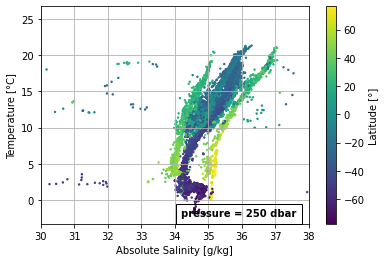

In [1]:
import numpy as np
import gsw.conversions
import numpy.matlib
import matplotlib.pyplot as plt
from netCDF4 import *

ds = Dataset('EN.4.2.1.f.profiles.g10.201901.nc')
    
# temperature (in degC)
T = ds.variables['TEMP'][:]

# practical salinity
PSAL = ds.variables['PSAL_CORRECTED'][:]

# depth
depth = ds.variables['DEPH_CORRECTED'][:]
    
lat = ds.variables['LATITUDE'][:]
long = ds.variables['LONGITUDE'][:]

def diagramTS(T, SP, depth, long, lat, p_layer):
    # Pressure from depth 
    p = gsw.p_from_z(-depth, np.matlib.repmat(lat,len(T[1,:]),1).T) # [dbar]
    
    # Absolute Salinity from Practical Salinity
    SA = gsw.SA_from_SP(SP, p, np.matlib.repmat(long,len(T[1,:]),1).T, np.matlib.repmat(lat,len(T[1,:]),1).T) # [g/kg]
    
    # in-situ density
    rho = gsw.rho(SA, T, p) # [kg/m^3]
    
    #p_find = np.where(p == p_layer)
    p_find = np.where((p > p_layer-1) & (p < p_layer+1))
    
    ax = plt.figure()
    marker_size=2
    plt.scatter(SA[p_find], T[p_find], marker_size, c=lat[p_find[0]])
    plt.xlabel("Absolute Salinity [g/kg]")
    plt.ylabel("Temperature [°C]")
    plt.grid()
    cbar= plt.colorbar()
    cbar.set_label("Latitude [°]")
    plt.xlim([30, 38])
    ax.text(0.45, 0.15, 'pressure = '+str(p_layer)+' dbar', weight='bold', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', pad=5))
    plt.show()
    return

diagramTS(T, PSAL, depth, long, lat, 250)